In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# importing required libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from keras.layers import Input, Embedding, LSTM, Dropout, BatchNormalization, Dense, concatenate, Flatten, Conv1D, MaxPool1D, LeakyReLU, ELU, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras import regularizers
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import roc_auc_score
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import re
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import pickle

Using TensorFlow backend.


In [3]:
# reading datasets
project_data = pd.read_csv("drive/My Drive/Donors for AFR Classroom/train_data.csv")
project_data.head()

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Health & Sports,"Health & Wellness, Team Sports",Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,2016-10-06 21:16:17,Grades PreK-2,"Literacy & Language, Math & Science","Literacy, Mathematics",Techie Kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,My students need to engage in Reading and Math...,4,1
4,172407,p104768,be1f7507a41f8479dc06f047086a39ec,Mrs.,TX,2016-07-11 01:10:09,Grades PreK-2,Math & Science,Mathematics,Interactive Math Tools,Our second grade classroom next year will be m...,"For many students, math is a subject that does...",NaN,NaN,My students need hands on practice in mathemat...,1,1


In [4]:
project_data["project_is_approved"].value_counts()

1    92706
0    16542
Name: project_is_approved, dtype: int64

In [5]:
resources = pd.read_csv("drive/My Drive/Donors for AFR Classroom/resources.csv")
resources.head()

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45
3,p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59
4,p069063,EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...,3,24.95


In [0]:
# We will combine these two datasets based on the id

price_data = resources.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [0]:
# It can been seen that there are some emtpy cells both for project_essay_3 and project_essay_4
# We will combine all the project essay columns into one single feature

project_data["text"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str) + \
                        project_data["project_title"]

In [0]:
project_data = project_data.drop(["project_essay_1","project_essay_2","project_essay_3","project_essay_4","project_title"],axis=1)

In [0]:
# We clean the essay text data
# For this task, we have defined some helper functions
# The same function and code snippet will be used to clean project title
# https://stackoverflow.com/a/47091490/4084039

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# https://gist.github.com/sebleier/554280

stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [10]:
# Cleaning Text feature
preprocessed_text = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['text'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_text.append(sent.lower().strip())

100%|██████████| 109248/109248 [01:09<00:00, 1580.08it/s]


In [0]:
project_data["clean_text"] = preprocessed_text

In [0]:
project_data = project_data.drop(['Unnamed: 0', 'id', 'teacher_id',
                                  'project_submitted_datetime','text'],axis=1)

In [0]:
# we have categorical features also, will do cleaning one by one

# https://stackoverflow.com/questions/36383821/pandas-dataframe-apply-function-to-column-strings-based-on-other-column-value
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace(' ','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace('-','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.lower()


project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' The ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace('&','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(',','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.lower()


project_data['teacher_prefix']=project_data['teacher_prefix'].fillna('Mrs.')
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.replace('.','')
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.lower()


project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' The ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace('&','_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(',','_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.lower()

project_data['school_state'] = project_data['school_state'].str.lower()

In [14]:
project_data.head()

,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity,clean_text
0,mrs,in,grades_prek_2,literacy_language,esl_literacy,My students need opportunities to practice beg...,0,0,154.60,23,my students english learners working english s...
1,mr,fl,grades_6_8,history_civics_health_sports,civics_government_teamsports,My students need a projector to help with view...,7,1,299.00,1,our students arrive school eager learn they po...
2,ms,az,grades_6_8,health_sports,health_wellness_teamsports,"My students need shine guards, athletic socks,...",1,0,516.85,22,true champions not always ones win guts by mia...
3,mrs,ky,grades_prek_2,literacy_language_math_science,literacy_mathematics,My students need to engage in Reading and Math...,4,1,232.90,4,i work unique school filled esl english second...
4,mrs,tx,grades_prek_2,math_science,mathematics,My students need hands on practice in mathemat...,1,1,67.98,4,our second grade classroom next year made arou...


In [15]:
# we will extract numerical digits from the project resource summary

project_summary_numerical = []
for sentance in tqdm(project_data['project_resource_summary']):
    sent1 = decontracted(sentance)
    sent1 = ' '.join(e for e in sent1.split() if e.isdigit())
    k=len(sent1)
    project_summary_numerical.append(k)

project_data["project_summary_numerical"] = project_summary_numerical

100%|██████████| 109248/109248 [00:01<00:00, 63301.73it/s]


In [0]:
target = project_data["project_is_approved"]
features = project_data.drop(["project_resource_summary","project_is_approved"],axis=1)

In [0]:
# We split our dataset into train,cross-validation and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target,stratify=target,test_size=0.25,random_state=123)

In [18]:
print(X_train.shape)
print("+++++++++++++")
print(X_test.shape)

(81936, 10)
+++++++++++++
(27312, 10)


In [0]:
# Filtering Text Data based on idf values

tfidf = TfidfVectorizer()
combine_tfidf = tfidf.fit_transform(X_train["clean_text"])

# converting to dictionary
combine_dict = dict(zip(tfidf.get_feature_names(),list(tfidf.idf_)))

In [0]:
tfidf_df = pd.DataFrame(list(combine_dict.items()), columns=['Words', 'IDF Values'])
tfidf_df = tfidf_df.sort_values(by ='IDF Values' )

Text(0.5, 1.0, 'Violin plot of idf')

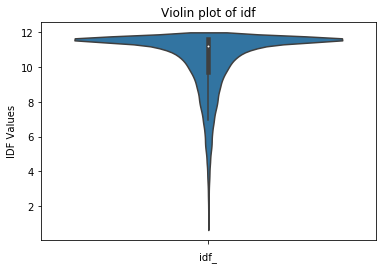

In [21]:
sns.violinplot(x = "IDF Values",data=tfidf_df,orient="v")
plt.xlabel("idf_")
plt.title("Violin plot of idf")

In [22]:
tfidf_df.head()

,Words,IDF Values
51286,students,1.007423
47336,school,1.160431
31087,my,1.242204
26998,learning,1.353505
9354,classroom,1.387552


In [23]:
tfidf_df.tail()

,Words,IDF Values
30449,monocrome,11.620559
30445,monkingbird,11.620559
30436,moniotring,11.620559
30468,monoprice,11.620559
58993,zzzzzzz,11.620559


In [0]:
corpus = tfidf_df[(tfidf_df['IDF Values'] >= 2) & (tfidf_df['IDF Values'] <=11 )]

In [25]:
corpus.shape

(27674, 2)

In [26]:
vocab = corpus["Words"].tolist()
vocab[:10]

['new',
 'year',
 'one',
 'these',
 'would',
 'time',
 'student',
 'want',
 'skills',
 'grade']

In [27]:
len(vocab)

27674

In [0]:
# MAX_SEQUENCE_LENGTH = 800
# MAX_VOCAB_SIZE = 1000000
EMBEDDING_DIM = 300

In [0]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(vocab)
sequences_train = tokenizer.texts_to_sequences(X_train["clean_text"])
sequences_test = tokenizer.texts_to_sequences(X_test["clean_text"])

In [0]:
length = []

for i in sequences_train:

  length.append(len(i))

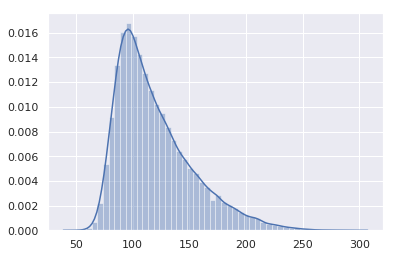

In [31]:
sns.set()
sns.distplot(length)

In [32]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 27674 unique tokens.


In [0]:
MAX_SEQUENCE_LENGTH = 100

In [34]:
encoded_train = pad_sequences(sequences_train,maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', encoded_train.shape)

Shape of data tensor: (81936, 100)


In [35]:
encoded_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', encoded_test.shape)

Shape of data tensor: (27312, 100)


In [0]:
# Loading Embedding File

pickle_in = open("drive/My Drive/Donors for AFR Classroom/glove_vectors","rb")
glove_words = pickle.load(pickle_in)

In [0]:
num_words = len(word2idx) + 1
embedding_matrix = np.zeros((num_words, 300))
for word, i in word2idx.items():
  if i < len(vocab):
    embedding_vector = glove_words.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

In [38]:
print(num_words)
print("+++++++++")
print(embedding_matrix.shape)

27675
+++++++++
(27675, 300)


In [39]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  300,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)
input_text = Input(shape=(MAX_SEQUENCE_LENGTH,),name="input_text")
x = embedding_layer(input_text)
# x = SpatialDropout1D(0.4)(x)
x = LSTM(256,dropout=0.5,kernel_regularizer=regularizers.l2(0.001),return_sequences=True)(x) # dropout=0.5
flatten_1 = Flatten()(x)

W0813 14:09:45.562907 139978809399168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0813 14:09:45.607234 139978809399168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0813 14:09:45.614454 139978809399168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0813 14:09:45.628221 139978809399168 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0813 14:09:45.629174 1399788093

In [0]:
vect = CountVectorizer(binary=True)
vect.fit(X_train["teacher_prefix"])

train_prefix = vect.transform(X_train["teacher_prefix"])
test_prefix = vect.transform(X_test["teacher_prefix"])

In [0]:
vect = CountVectorizer(binary=True)
vect.fit(X_train["school_state"])

train_state = vect.transform(X_train["school_state"])
test_state = vect.transform(X_test["school_state"])

In [0]:
vect = CountVectorizer(binary=True)
vect.fit(X_train["project_grade_category"])

train_grade = vect.transform(X_train["project_grade_category"])
test_grade = vect.transform(X_test["project_grade_category"])

In [0]:
vect = CountVectorizer(binary=True)
vect.fit(X_train["project_subject_categories"])

train_subcat = vect.transform(X_train["project_subject_categories"])
test_subcat = vect.transform(X_test["project_subject_categories"])

In [0]:
vect = CountVectorizer(binary=True)
vect.fit(X_train["project_subject_subcategories"])

train_subcat_1 = vect.transform(X_train["project_subject_subcategories"])
test_subcat_1 = vect.transform(X_test["project_subject_subcategories"])

In [0]:
# Now we will prepare numerical features for our model
num_train_1=X_train['project_summary_numerical'].values.reshape(-1, 1)
num_train_2=X_train['price'].values.reshape(-1, 1)
num_train_3=X_train['quantity'].values.reshape(-1, 1)
num_train_4=X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

num_test_1=X_test['project_summary_numerical'].values.reshape(-1, 1)
num_test_2=X_test['price'].values.reshape(-1, 1)
num_test_3=X_test['quantity'].values.reshape(-1, 1)
num_test_4=X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)


num_train=np.concatenate((num_train_1,num_train_2,num_train_3,num_train_4),axis=1)

num_test=np.concatenate((num_test_1,num_test_2,num_test_3,num_test_4),axis=1)


from sklearn.preprocessing import StandardScaler
norm=StandardScaler()
norm_train=norm.fit_transform(num_train)
norm_test=norm.transform(num_test)

In [0]:
from scipy.sparse import hstack
other_train = hstack([train_prefix,train_state,train_grade,train_subcat,train_subcat_1]).todense()
other_test = hstack([test_prefix,test_state,test_grade,test_subcat,test_subcat_1]).todense()

In [0]:
other_all_train = np.hstack((other_train,norm_train))
other_all_test = np.hstack((other_test,norm_test))

In [0]:
other_train_ = np.expand_dims(other_all_train,2)
other_test_ = np.expand_dims(other_all_test,2)

In [49]:
print(other_train_.shape)
print("++++++++++++++")
print(other_test_.shape)

(81936, 512, 1)
++++++++++++++
(27312, 512, 1)


In [0]:
inp_conv =  Input(shape=(512, 1),name='features_all')
x1 = Conv1D(filters=128, kernel_size=3, activation='relu',kernel_initializer="he_normal")(inp_conv)
x1 = Conv1D(filters=128, kernel_size=3, activation='relu',kernel_initializer="he_normal")(x1)
# x1 = Conv1D(filters=256, kernel_size=5, activation='relu',kernel_initializer="he_normal")(x1)
# x1 = Conv1D(filters=128, kernel_size=5, activation='relu',kernel_initializer="he_normal")(x1)
x3 = Flatten()(x1)

In [51]:
print("Building Model-3")
x_concatenate = concatenate([flatten_1,x3])
# x_concatenate = BatchNormalization()(x_concatenate)
x = Dense(128,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x_concatenate)
# x=LeakyReLU(alpha=0.3)(x)
x=Dropout(0.5)(x)
x = Dense(64,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
# x=LeakyReLU(alpha=0.3)(x)
x=Dropout(0.3)(x)
x = Dense(32,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
# x = BatchNormalization()(x)
# x=LeakyReLU(alpha=0.3)(x)
output = Dense(2, activation='softmax', name='output')(x)
model_3 = Model(inputs=[input_text,inp_conv],outputs=[output])

Building Model-3


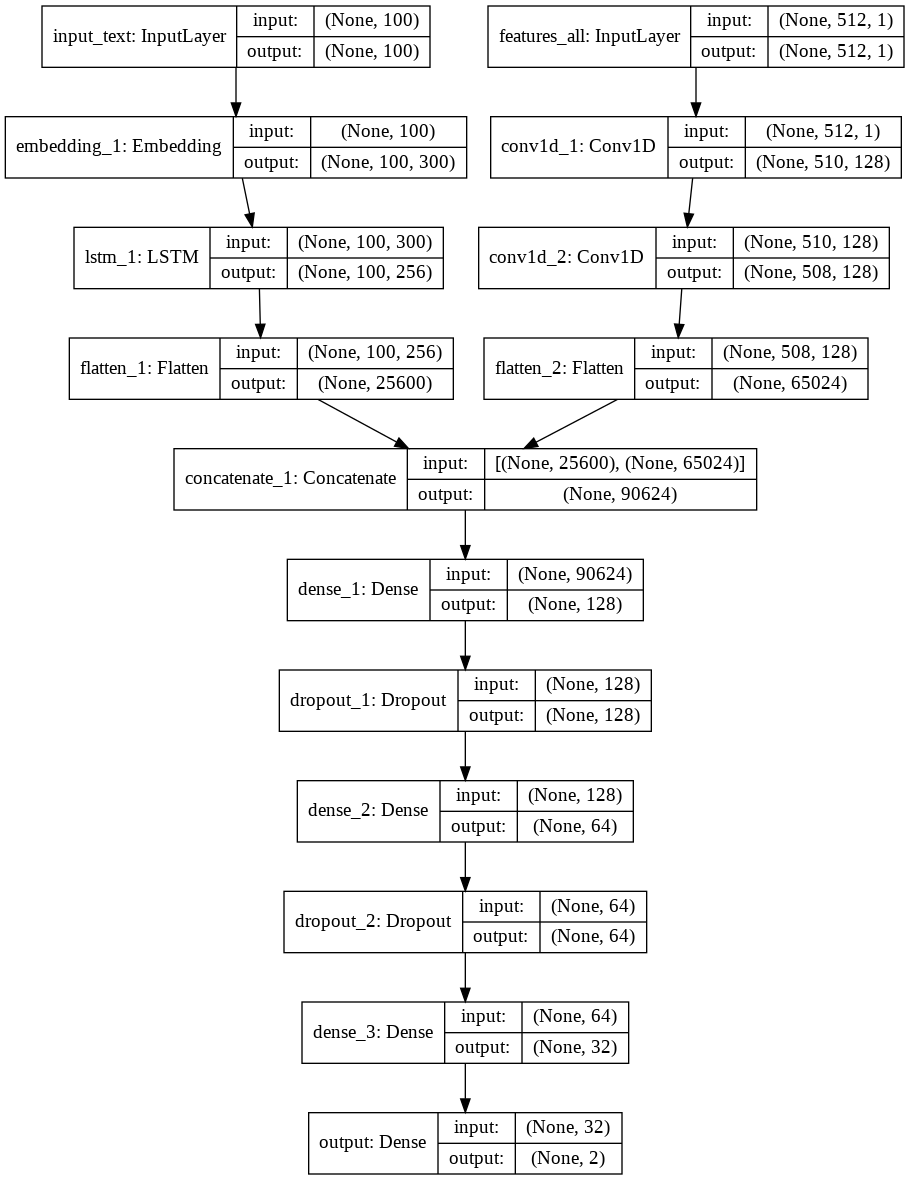

In [52]:
# https://github.com/mmortazavi/EntityEmbedding-Working_Example/blob/master/EntityEmbedding.ipynb
from keras.utils import plot_model
import pydot_ng as pydot
plot_model(model_3, show_shapes=True, show_layer_names=True, to_file='model_3.png')
from IPython.display import Image
Image(retina=True, filename='model_3.png')

In [0]:
train_data_3 = [encoded_train,other_train_]
test_data_3 = [encoded_test,other_test_]

from keras.utils import np_utils
Y_train = np_utils.to_categorical(y_train, 2) 
Y_test = np_utils.to_categorical(y_test, 2)

In [0]:
checkpoint_3 = ModelCheckpoint("model_3.h5",
                             monitor="val_auroc",
                             mode="max",
                             save_best_only = True,
                             verbose=1)

# earlystop_3 = EarlyStopping(monitor = 'val_loss', 
#                             mode="min",
#                             min_delta = 0, 
#                             patience = 2,
#                             verbose = 1,
#                             restore_best_weights = True)

# reduce_lr_3 = ReduceLROnPlateau(monitor = 'val_auroc', factor = 0.2, patience = 2, verbose = 1, min_delta = 0.0001)

tensorboard_3 = TensorBoard(log_dir='graph_3', histogram_freq=0, batch_size=512, write_graph=True, write_grads=True, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')

callbacks_3 = [tensorboard_3,checkpoint_3]

In [0]:
# Defining Custom ROC-AUC Metrics
from sklearn.metrics import roc_auc_score

def auc1(y_true, y_pred):
    if len(np.unique(y_true[:,1])) == 1:
        return 0.5
    else:
        return roc_auc_score(y_true, y_pred)

def auroc(y_true, y_pred):
    return tf.py_func(auc1, (y_true, y_pred), tf.double)

In [0]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
rms = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
# ,clipvalue=0.4

In [0]:
model_3.compile(optimizer=adam, loss='categorical_crossentropy', metrics=[auroc])

In [63]:
history_3 = model_3.fit(train_data_3,Y_train,batch_size=512,
                        epochs=30,validation_data=(test_data_3,Y_test),callbacks=callbacks_3)

Train on 81936 samples, validate on 27312 samples
Epoch 1/30
81936/81936 [==============================] - 81s 983us/step - loss: 0.4117 - auroc: 0.7414 - val_loss: 0.3942 - val_auroc: 0.7628

Epoch 00001: val_auroc improved from -inf to 0.76279, saving model to model_3.h5
Epoch 2/30
81936/81936 [==============================] - 78s 957us/step - loss: 0.3941 - auroc: 0.7488 - val_loss: 0.3859 - val_auroc: 0.7655

Epoch 00002: val_auroc improved from 0.76279 to 0.76549, saving model to model_3.h5
Epoch 3/30
81936/81936 [==============================] - 79s 959us/step - loss: 0.3882 - auroc: 0.7557 - val_loss: 0.3873 - val_auroc: 0.7672

Epoch 00003: val_auroc improved from 0.76549 to 0.76719, saving model to model_3.h5
Epoch 4/30
81936/81936 [==============================] - 78s 957us/step - loss: 0.3830 - auroc: 0.7569 - val_loss: 0.3778 - val_auroc: 0.7680

Epoch 00004: val_auroc improved from 0.76719 to 0.76804, saving model to model_3.h5
Epoch 5/30
81936/81936 [=================

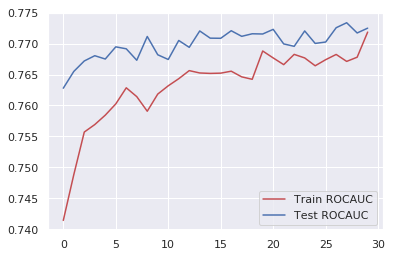

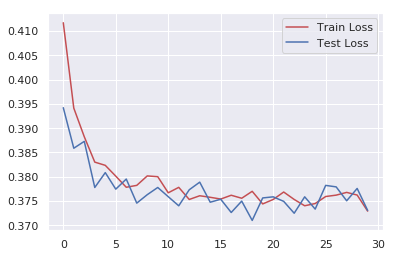

In [64]:
sns.set()
plt.plot(history_3.history['auroc'], 'r')
plt.plot(history_3.history['val_auroc'], 'b')
plt.legend({'Train ROCAUC': 'r', 'Test ROCAUC':'b'})
plt.show()


plt.plot(history_3.history['loss'], 'r')
plt.plot(history_3.history['val_loss'], 'b')
plt.legend({'Train Loss': 'r', 'Test Loss':'b'})
plt.show()

Training Loss:

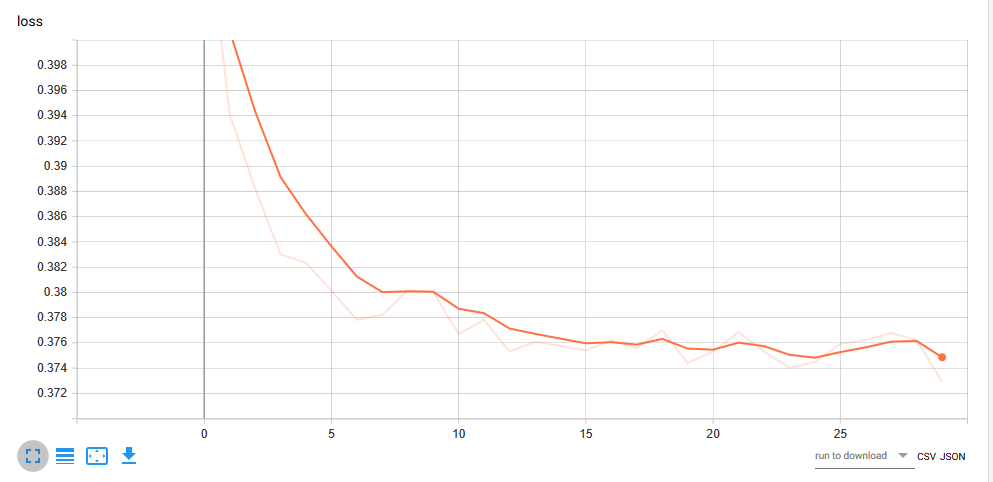

Train ROC AUC:

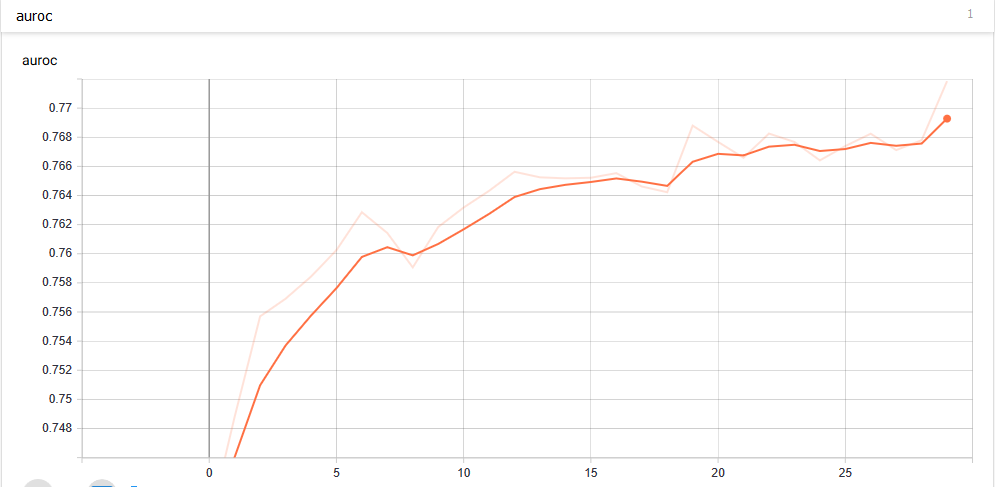

Test Loss:

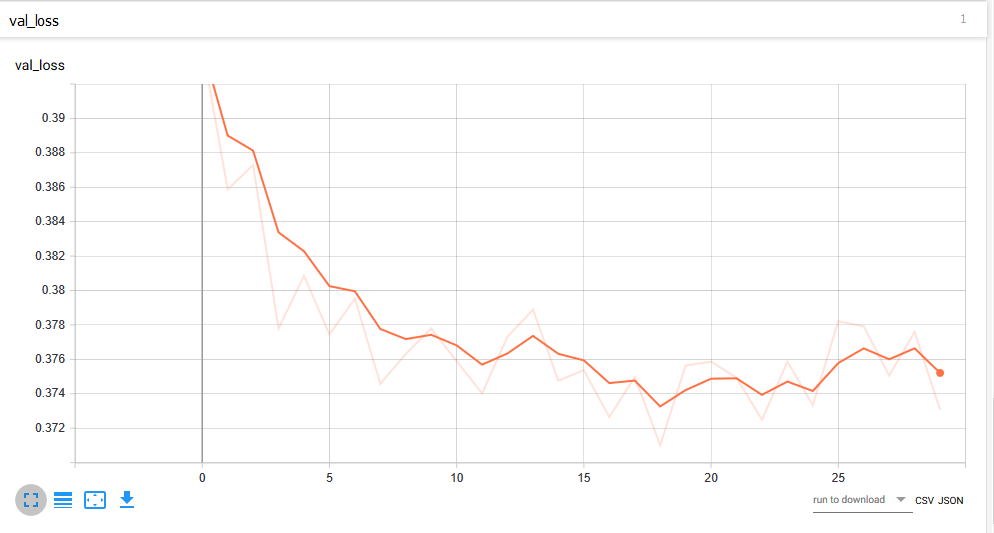

Test ROC AUC

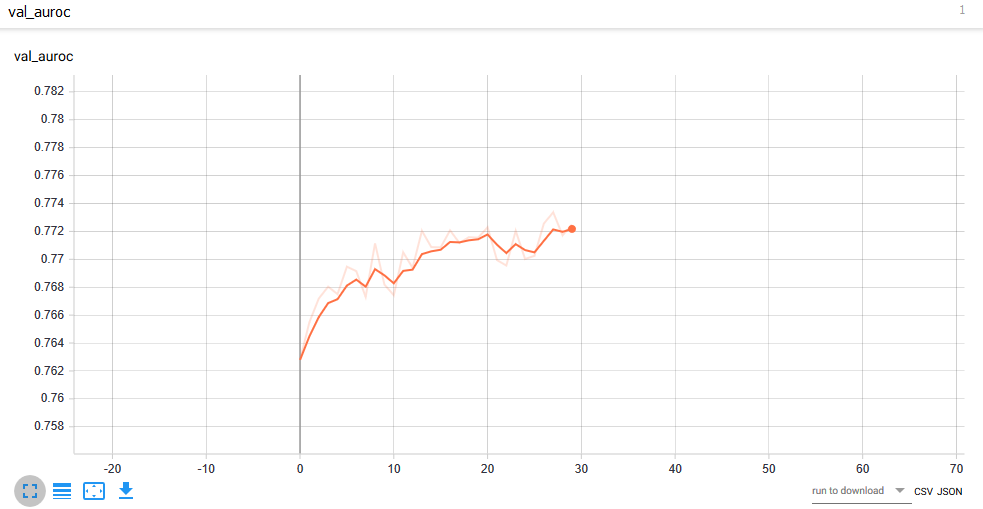

Conclusions : Out of three models, using this I manage to achieve 0.77 AUC, which is highest. Had Used Vocab Size i.e. filtered on the idf scores. Because of this sequence length of 100 can be taken, which increased the training time to a large extent. Used regularizers in order to make the model not to overfit.